# Bro Network Monitor

Data Link: https://www.dropbox.com/sh/7fo4efxhpenexqp/AACmuri_l-LDiVDUDJ3hVLqPa?dl=0

This tutorial is based on one from ClickSecurity's Data_hacking repo: https://github.com/carriegardner428/data_hacking/blob/master/contagio_traffic_analysis/contagio_traffic_analysis.ipynb

# Collect Data Samples

This dataset represents samples of malicious network traffic from {}.  Samples are classified into "APT", "CRIME", and "METASPLOIT", and are further divided into sample grouping

In [30]:
import os
import pandas as pd
from datetime import datetime

In [58]:
# Mapping of fields of the files we want to read in and initial setup of pandas dataframes
logs_to_process = {
                    'conn.log' : ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','proto','service','duration','orig_bytes','resp_bytes','conn_state','local_orig','missed_bytes','history','orig_pkts','orig_ip_bytes','resp_pkts','resp_ip_bytes','tunnel_parents','threat','sample'],
                    'dns.log' : ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','proto','trans_id','query','qclass','qclass_name','qtype','qtype_name','rcode','rcode_name','AA','TC','RD','RA','Z','answers','TTLs','rejected','threat','sample'],
                    'files.log' : ['ts','fuid','tx_hosts','rx_hosts','conn_uids','source','depth','analyzers','mime_type','filename','duration','local_orig','is_orig','seen_bytes','total_bytes','missing_bytes','overflow_bytes','timedout','parent_fuid','md5','sha1','sha256','extracted','threat','sample'],
                    'ftp.log' : ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','user','password','command','arg','mime_type','file_size','reply_code','reply_msg','data_channel.passive','data_channel.orig_h','data_channel.resp_h','data_channel.resp_p','fuid','threat','sample'],
                    'http.log' : ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','trans_depth','method','host','uri','referrer','user_agent','request_body_len','response_body_len','status_code','status_msg','info_code','info_msg','filename','tags','username','password','proxied','orig_fuids','orig_mime_types','resp_fuids','resp_mime_types','threat','sample'],
                    'notice.log' : ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','fuid','file_mime_type','file_desc','proto','note','msg','sub','src','dst','p','n','peer_descr','actions','suppress_for','dropped','remote_location.country_code','remote_location.region','remote_location.city','remote_location.latitude','remote_location.longitude','threat','sample'],
                    'signatures.log' : ['ts','src_addr','src_port','dst_addr','dst_port','note','sig_id','event_msg','sub_msg','sig_count','host_count','threat','sample'],
                    'smtp.log' : ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','trans_depth','helo','mailfrom','rcptto','date','from','to','reply_to','msg_id','in_reply_to','subject','x_originating_ip','first_received','second_received','last_reply','path','user_agent','fuids','is_webmail','threat','sample'],
                    'ssl.log' : ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','version','cipher','server_name','session_id','subject','issuer_subject','not_valid_before','not_valid_after','last_alert','client_subject','client_issuer_subject','cert_hash','validation_status','threat','sample'],
                    'tunnel.log' : ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','tunnel_type','action','threat','sample'],
                    'weird.log' : ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','name','addl','notice','peer','threat','sample']
                  }

conndf   = pd.DataFrame(columns=logs_to_process['conn.log'])
dnsdf    = pd.DataFrame(columns=logs_to_process['dns.log'])
filesdf  = pd.DataFrame(columns=logs_to_process['files.log'])
ftpdf    = pd.DataFrame(columns=logs_to_process['ftp.log'])
httpdf   = pd.DataFrame(columns=logs_to_process['http.log'])
noticedf = pd.DataFrame(columns=logs_to_process['notice.log'])
sigdf    = pd.DataFrame(columns=logs_to_process['signatures.log'])
smtpdf   = pd.DataFrame(columns=logs_to_process['smtp.log'])
ssldf    = pd.DataFrame(columns=logs_to_process['ssl.log'])
tunneldf = pd.DataFrame(columns=logs_to_process['tunnel.log'])
weirddf  = pd.DataFrame(columns=logs_to_process['weird.log'])

In [59]:
def clean_timestamp(df):
    # Reference: https://github.com/carriegardner428/data_hacking/blob/master/contagio_traffic_analysis/contagio_traffic_analysis.ipynb
    # DROP RECORDS THAT DON'T HAVE A TIMESTAMP ('#CLOSE')
    df = df[df.ts.str.contains("#close") == False]
    df_time = [datetime.fromtimestamp(float(date)) for date in df['ts'].values ]
    df['timestamp'] = pd.Series(df_time)
    df.drop('ts', axis=1, inplace=True)
    df.set_index('timestamp', inplace=True)
    return df

In [60]:
for dirName, subdirList, fileList in os.walk('./data/PCAPS_TRAFFIC_PATTERNS/'):
    for fname in fileList:
        tags = dirName.split('/')
        if len(tags) == 5 and fname in logs_to_process:
            logname = fname.split('.')
            try:
                tempdf = pd.read_csv(dirName+'/'+fname, sep='\t',skiprows=8, header=None, 
                                     names=logs_to_process[fname][:-2])
                tempdf['threat'] = tags[3]
                tempdf['sample'] = tags[4]
                tempdf = clean_timestamp(tempdf)
                if tags[2] == "0":
                    print ('%s/%s' %(dirName, fname))
                if fname == 'conn.log':
                    conndf = conndf.append(tempdf)
                if fname == 'dns.log':
                    dnsdf = dnsdf.append(tempdf)
                if fname == 'files.log':
                    filesdf = filesdf.append(tempdf)
                if fname == 'ftp.log':
                    ftpdf = ftpdf.append(tempdf)
                if fname == 'http.log':
                    httpdf = httpdf.append(tempdf)
                if fname == 'notice.log':
                    noticedf = noticedf.append(tempdf)
                if fname == 'signatures.log':
                    sigdf = sigdf.append(tempdf)
                if fname == 'smtp.log':
                    smtpdf = smtpdf.append(tempdf)
                if fname == 'ssl.log':
                    ssldf = ssldf.append(tempdf)
                if fname == 'tunnel.log':
                    tunneldf = tunneldf.append(tempdf)
                if fname == 'weird.log':
                    weirddf = weirddf.append(tempdf)
            except Exception as e:
                print("Error: {}, on {}/{}".format(str(e), dirName, fname))

/Users/carrie/anaconda/envs/mlbook/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/carrie/anaconda/envs/mlbook/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/carrie/anaconda/envs/mlbook/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Handling BAD, DIRTY Data!!!

### Let's check the timestamp column

In [69]:
conndf.shape

(51743, 22)

In [74]:
conndf.sort_index(inplace=True)
conndf.index.year.unique()

Int64Index([2008, 2010, 2011, 2012, 2013], dtype='int64')

*Where computers even around in 1969?*

(Yes, LOL ;) ).  But this sample is from roughly 2008-2013.  Let's make a new df with records just in that time interval

In [68]:
conndf = conndf['2008':'2013']
conndf.shape

(51743, 22)

you can use df['start_time/date':'end_time/date'] to subset a collection of records in a timeframe

In [75]:
conndf.index.year.unique()

Int64Index([2008, 2010, 2011, 2012, 2013], dtype='int64')

### Let's check the times of the other dataframes

dns.log

In [77]:
dnsdf.sort_index(inplace=True)
dnsdf.index.year.unique()

Float64Index([1969.0, 2010.0, 2011.0, 2012.0, 2013.0, nan], dtype='float64')

In [87]:
dnsdf.shape

(42835, 25)

In [88]:
dnsdf = dnsdf['2010':'2013']
dnsdf.shape

(35101, 25)

files.log

In [78]:
filesdf.sort_index(inplace=True)
filesdf.index.year.unique()

Int64Index([1969, 2008, 2010, 2011, 2012, 2013], dtype='int64')

In [89]:
filesdf.shape

(19289, 25)

In [90]:
filesdf = filesdf['2008':'2013']
filesdf.shape

(19087, 25)

ftp.log

In [79]:
ftpdf.sort_index(inplace=True)
ftpdf.index.year.unique()

Int64Index([1969, 2013], dtype='int64')

In [91]:
ftpdf.shape

(3, 21)

In [92]:
ftpdf = ftpdf['2013']
ftpdf.shape

(2, 21)

http.log

In [80]:
httpdf.sort_index(inplace=True)
httpdf.index.year.unique()

Int64Index([1969, 2008, 2010, 2011, 2012, 2013], dtype='int64')

In [93]:
httpdf.shape

(22927, 29)

In [94]:
httpdf = httpdf['2008':'2013']
httpdf.shape

(22798, 29)

notice.log

In [81]:
noticedf.sort_index(inplace=True)
noticedf.index.year.unique()

Int64Index([1969, 2011, 2012, 2013], dtype='int64')

In [95]:
noticedf.shape

(252, 28)

In [96]:
noticedf = noticedf['2011':'2013']
noticedf.shape

(248, 28)

sig.log

In [82]:
sigdf.sort_index(inplace=True)
sigdf.index.year.unique()

Int64Index([2012], dtype='int64')

In [97]:
sigdf.shape

(1, 13)

smtp.log

In [83]:
smtpdf.sort_index(inplace=True)
smtpdf.index.year.unique()

Int64Index([2012, 2013], dtype='int64')

In [99]:
smtpdf.shape

(4088, 27)

ssl.log

In [84]:
ssldf.sort_index(inplace=True)
ssldf.index.year.unique()

Int64Index([1969, 2011, 2012, 2013], dtype='int64')

In [100]:
ssldf.shape

(351, 21)

In [101]:
ssldf = ssldf['2011':'2013']
ssldf.shape

(346, 21)

tunnel.log

In [85]:
tunneldf.sort_index(inplace=True)
tunneldf.index.year.unique()

Int64Index([2013], dtype='int64')

In [102]:
tunneldf.shape

(2, 10)

weird.log

In [86]:
weirddf.sort_index(inplace=True)
weirddf.index.year.unique()

Int64Index([1969, 2011, 2012, 2013], dtype='int64')

In [103]:
weirddf.shape

(1081, 12)

In [105]:
weirddf = weirddf['2011':'2013']
weirddf.shape

(1037, 12)

## Checking Other Features
- NaNs
- Single value features

### conn.log

In [34]:
conndf.head()

,conn_state,duration,history,id.orig_h,id.orig_p,id.resp_h,id.resp_p,local_orig,missed_bytes,orig_bytes,...,orig_pkts,proto,resp_bytes,resp_ip_bytes,resp_pkts,sample,service,threat,tunnel_parents,uid
2013-02-03 17:20:28.793176,SF,21.708771,Dd,172.16.253.129,68.0,172.16.253.254,67.0,-,0.0,301,...,1.0,udp,900,984.0,3.0,BIN_8202_6d2c12085f0018daeb9c1a53e53fd4d1,dhcp,APT,(empty),CI9ceD4wNSKUHA3wmd
2013-02-03 17:20:49.634244,S0,0.863748,D,0.0.0.0,68.0,255.255.255.255,67.0,-,0.0,613,...,2.0,udp,0,0.0,0.0,BIN_8202_6d2c12085f0018daeb9c1a53e53fd4d1,dhcp,APT,(empty),CmHWaWNDdsoHVqVsk
2013-02-03 17:20:49.635240,OTH,0.000007,-,172.16.253.254,8.0,172.16.253.129,0.0,-,0.0,40,...,2.0,icmp,0,0.0,0.0,BIN_8202_6d2c12085f0018daeb9c1a53e53fd4d1,-,APT,(empty),C82nAi1NNM7gxFM7T2
2013-02-03 17:22:44.875318,SF,0.115893,Dd,172.16.253.129,53.0,8.8.8.8,53.0,-,0.0,41,...,1.0,udp,57,85.0,1.0,BIN_8202_6d2c12085f0018daeb9c1a53e53fd4d1,dns,APT,(empty),CgldPv2fme1uRfxBG4
2013-02-03 17:22:44.875379,SF,0.114048,Dd,172.16.253.129,53.0,4.2.2.2,53.0,-,0.0,41,...,1.0,udp,57,85.0,1.0,BIN_8202_6d2c12085f0018daeb9c1a53e53fd4d1,dns,APT,(empty),CEAjpT2procZiZLkpl


In [106]:
conndf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51743 entries, 2008-08-29 14:13:19.056673 to 2013-09-25 22:44:06.949527
Data columns (total 22 columns):
conn_state        51743 non-null object
duration          51743 non-null object
history           51743 non-null object
id.orig_h         51743 non-null object
id.orig_p         51743 non-null float64
id.resp_h         51743 non-null object
id.resp_p         51743 non-null float64
local_orig        51743 non-null object
missed_bytes      51743 non-null float64
orig_bytes        51743 non-null object
orig_ip_bytes     51743 non-null float64
orig_pkts         51743 non-null float64
proto             51743 non-null object
resp_bytes        51743 non-null object
resp_ip_bytes     51743 non-null float64
resp_pkts         51743 non-null float64
sample            51743 non-null object
service           51743 non-null object
threat            51743 non-null object
ts                0 non-null object
tunnel_parents    51743 non-null object

In [131]:
# Get categorical, object-type variables
conndf.select_dtypes(include=['object']).describe()

,conn_state,duration,history,id.orig_h,id.resp_h,local_orig,orig_bytes,proto,resp_bytes,sample,service,threat,tunnel_parents,uid
count,51743,51743,51743,51743,51743,51743,51743,51743,51743,51743,51743,51743,51743,51743
unique,13,38352,174,111,3861,1,3479,3,4629,95,9,3,2,51743
top,RSTO,-,ShAfR,192.168.248.165,10.0.2.255,-,0,tcp,-,BIN_Kuluoz-Asprox_9F842AD20C50AD1AAB41F20B321B...,-,CRIME,(empty),Ccf1Kq4YilW9TJ9di6
freq,20739,10920,9974,23641,2756,51743,21169,43381,10920,17510,31585,48725,51741,1


In [ ]:
conndf['local_orig'].unique()

In [135]:
conndf.tunnel_parents.value_counts()

(empty)              51741
CDlYaUKSPEa6CZWm6        2
Name: tunnel_parents, dtype: int64

In [136]:
conndf.conn_state.value_counts()

RSTO      20739
S0        11951
SF        10882
RSTRH      3269
SHR        1416
REJ        1253
RSTR       1045
OTH         479
RSTOS0      255
S3          128
SH          127
S1          117
S2           82
Name: conn_state, dtype: int64

In [134]:
# Get categorical, object-type variables
conndf.select_dtypes(exclude=['object']).describe()

,id.orig_p,id.resp_p,missed_bytes,orig_ip_bytes,orig_pkts,resp_ip_bytes,resp_pkts
count,51743.000000,51743.000000,5.174300e+04,5.174300e+04,51743.000000,5.174300e+04,51743.000000
mean,3527.059892,1003.664302,1.562934e+02,1.257999e+03,6.740351,5.544762e+03,7.629109
std,7916.361162,3599.388695,3.542275e+04,5.133977e+04,86.552072,1.669139e+05,123.460882
min,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,1356.000000,25.000000,0.000000e+00,7.800000e+01,1.000000,4.000000e+01,1.000000
50%,2207.000000,80.000000,0.000000e+00,1.680000e+02,4.000000,1.580000e+02,2.000000
75%,3319.000000,80.000000,0.000000e+00,5.080000e+02,5.000000,5.170000e+02,4.000000
max,65529.000000,63551.000000,8.057592e+06,1.074928e+07,13493.000000,3.046285e+07,20340.000000


conndf TODOs:
    - drop 'ts' column
    - drop 'local_orig' column, 1 unique

In [126]:
conndf.drop('ts', axis=1, inplace=True)
conndf.drop('local_orig', axis=1, inplace=True)
conndf.info()

ValueError: labels ['ts'] not contained in axis

### dns.log

In [15]:
dnsdf.head()

,AA,RA,RD,TC,TTLs,Z,answers,id.orig_h,id.orig_p,id.resp_h,...,qtype,qtype_name,query,rcode,rcode_name,rejected,sample,threat,trans_id,uid
2013-02-03 17:22:44.875379,F,T,T,F,700,0.0,192.200.99.194,172.16.253.129,53.0,4.2.2.2,...,1,A,sa.foundcloudsearch.com,0,NOERROR,F,BIN_8202_6d2c12085f0018daeb9c1a53e53fd4d1,APT,27825.0,CEAjpT2procZiZLkpl
2013-02-03 17:22:44.875318,F,T,T,F,2502,0.0,192.200.99.194,172.16.253.129,53.0,8.8.8.8,...,1,A,sa.foundcloudsearch.com,0,NOERROR,F,BIN_8202_6d2c12085f0018daeb9c1a53e53fd4d1,APT,27825.0,CgldPv2fme1uRfxBG4
2013-01-05 22:45:24.874503,F,F,F,F,-,0.0,-,172.16.253.129,1143.0,199.36.76.113,...,-,-,-,0,NOERROR,F,BIN_9002_D4ED654BCDA42576FDDFE03361608CAA_2013...,APT,0.0,CbH3Rf1eTZNnvfSek7
2013-01-05 22:45:44.391876,F,F,F,F,-,0.0,-,172.16.253.129,1143.0,199.36.76.113,...,-,-,-,-,-,T,BIN_9002_D4ED654BCDA42576FDDFE03361608CAA_2013...,APT,0.0,CbH3Rf1eTZNnvfSek7
2013-01-05 22:47:24.922913,F,F,F,F,-,0.0,-,172.16.253.129,1143.0,199.36.76.113,...,-,-,-,-,-,F,BIN_9002_D4ED654BCDA42576FDDFE03361608CAA_2013...,APT,0.0,CbH3Rf1eTZNnvfSek7


In [137]:
dnsdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35101 entries, 2010-02-13 09:23:18.490261 to 2013-09-25 22:37:25.795640
Data columns (total 25 columns):
AA             35101 non-null object
RA             35101 non-null object
RD             35101 non-null object
TC             35101 non-null object
TTLs           35101 non-null object
Z              35101 non-null float64
answers        35101 non-null object
id.orig_h      35101 non-null object
id.orig_p      35101 non-null float64
id.resp_h      35101 non-null object
id.resp_p      35101 non-null float64
proto          35101 non-null object
qclass         35101 non-null object
qclass_name    35101 non-null object
qtype          35101 non-null object
qtype_name     35101 non-null object
query          35101 non-null object
rcode          35101 non-null object
rcode_name     35101 non-null object
rejected       35101 non-null object
sample         35101 non-null object
threat         35101 non-null object
trans_id       35101 non-

In [138]:
# Get categorical, object-type variables
dnsdf.select_dtypes(include=['object']).describe()

,AA,RA,RD,TC,TTLs,answers,id.orig_h,id.resp_h,proto,qclass,...,qtype,qtype_name,query,rcode,rcode_name,rejected,sample,threat,ts,uid
count,35101,35101,35101,35101,35101,35101,35101,35101,35101,35101,...,35101,35101,35101,35101,35101,35101,35101,35101,0.0,35101
unique,2,2,2,1,3937,3164,42,50,2,3,...,13,9,3195,10,7,2,82,2,0.0,4803
top,F,F,T,F,-,-,192.168.248.165,10.0.2.255,udp,1,...,32,NB,NOLOGO1093.COM,-,-,F,BIN_CitadelPacked_2012-05,CRIME,NaN,CEAizT2ntuLyinqtPa
freq,35098,27552,32444,35101,27706,27706,13673,13013,34714,26103,...,13875,15167,6544,22183,22183,34395,13395,33893,NaN,3415


In [139]:
dnsdf.rejected.value_counts()

F    34395
T      706
Name: rejected, dtype: int64

In [140]:
dnsdf.qclass_name.value_counts()

C_INTERNET    34563
-               538
Name: qclass_name, dtype: int64

In [141]:
dnsdf.TC.value_counts()

F    35101
Name: TC, dtype: int64

In [142]:
# Get categorical, object-type variables
dnsdf.select_dtypes(exclude=['object']).describe()

,Z,id.orig_p,id.resp_p,trans_id
count,35101.000000,35101.000000,35101.000000,35101.000000
mean,0.396257,1486.173984,121.646705,32466.772314
std,0.489126,8516.369410,411.977287,13436.185471
min,0.000000,53.000000,53.000000,0.000000
25%,0.000000,53.000000,53.000000,27352.000000
50%,0.000000,137.000000,53.000000,33968.000000
75%,1.000000,137.000000,137.000000,36884.000000
max,1.000000,65529.000000,5355.000000,65534.000000


In [143]:
dnsdf.Z.value_counts()

0.0    21192
1.0    13909
Name: Z, dtype: int64

dnsdf TODOs:
    - drop 'ts' column
    - drop 'tc' column, 1 unique

In [145]:
dnsdf.drop('ts', axis=1, inplace=True)
dnsdf.drop('TC', axis=1, inplace=True)
dnsdf.head()

ValueError: labels ['ts'] not contained in axis

### file.log

In [16]:
filesdf.head()

,analyzers,conn_uids,depth,duration,extracted,filename,fuid,is_orig,local_orig,md5,...,rx_hosts,sample,seen_bytes,sha1,sha256,source,threat,timedout,total_bytes,tx_hosts
2012-10-07 10:45:05.260590,"MD5,SHA1",ClpERK2U3EJh2Sp7zj,0.0,0.000000,-,-,FF3ky62ppNbz5xz0Z2,F,-,4dec45889e09ec3ceb63fd65825d0f11,...,172.16.253.130,BIN_DNSWatch_protux_4F8A44EF66384CCFAB737C8D7A...,564.0,d80eaf048573a410cb6c49ebb859280d04b6113c,-,HTTP,APT,F,564,82.96.118.210
2011-07-19 19:25:04.678615,"SHA1,MD5",CFxQyaLHN8gDJbqQ3,0.0,0.000000,-,-,Fx05J53kcY5j1YUwfc,F,-,7eb1866f3e37ba63e7d9a2762536d0e4,...,172.29.0.116,BIN_LetsGo_yahoosb_b21ba443726385c11802a8ad731...,131.0,413dcf4056b982ffd385a92d265458fc66f1ac5d,-,HTTP,APT,F,131,58.64.232.19
2011-07-19 19:25:04.974835,"SHA1,MD5",CFxQyaLHN8gDJbqQ3,0.0,11.564372,-,-,F5Vnf2F0SEKDwTpKb,F,-,2eca000bd0a628a6905f898343a4a449,...,172.29.0.116,BIN_LetsGo_yahoosb_b21ba443726385c11802a8ad731...,282317.0,49ded6741d9996eb759c5e2b6ab2f6ec2e5faf13,-,HTTP,APT,F,289628,58.64.232.19
2012-10-07 10:34:52.937534,"MD5,SHA1",CUBtNl42Jz57iOSkb5,0.0,0.000000,-,-,F6UVLD2KuRsWDNNgRj,F,-,23d6b92bc7eb100fc1294e6b124b7e75,...,172.16.253.129,BIN_Likseput_E019E37F19040059AB5662563F06B609_...,1635.0,f0649f9495d1f566a3f690002050b87800b4bce2,-,HTTP,APT,F,1635,205.209.161.13
2012-10-07 17:50:41.483734,"SHA1,MD5",CtH2QO2HwW4Zu2gVl1,0.0,0.000000,-,-,FOvQBu21DhExBT6OAh,F,-,2e8ba2d348ff0ae9e930efd1c7218d25,...,172.16.253.240,BIN_Mediana_0AE47E3261EA0A2DBCE471B28DFFE007_2...,522.0,ad5c88987c80091eff1cf7915ef346016dcd644b,-,HTTP,APT,F,522,118.69.36.139


In [147]:
filesdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19087 entries, 2008-08-29 14:13:19.062835 to 2013-09-25 22:22:33.349323
Data columns (total 25 columns):
analyzers         19087 non-null object
conn_uids         19087 non-null object
depth             19087 non-null float64
duration          19087 non-null float64
extracted         19087 non-null object
filename          19087 non-null object
fuid              19087 non-null object
is_orig           19087 non-null object
local_orig        19087 non-null object
md5               19087 non-null object
mime_type         19087 non-null object
missing_bytes     19087 non-null float64
overflow_bytes    19087 non-null float64
parent_fuid       19087 non-null object
rx_hosts          19087 non-null object
sample            19087 non-null object
seen_bytes        19087 non-null float64
sha1              19087 non-null object
sha256            19087 non-null object
source            19087 non-null object
threat            19087 non-null obje

In [148]:
# Get categorical, object-type variables
filesdf.select_dtypes(include=['object']).describe()

,analyzers,conn_uids,extracted,filename,fuid,is_orig,local_orig,md5,mime_type,parent_fuid,rx_hosts,sample,sha1,sha256,source,threat,timedout,total_bytes,ts,tx_hosts
count,19087,19087,19087,19087,19087,19087,19087,19087,19087,19087,19087,19087,19087,19087,19087,19087,19087,19087,0.0,19087
unique,3,10005,1,54,19076,2,1,8884,26,1,363,77,8884,1,3,3,2,3552,0.0,1449
top,"SHA1,MD5",CH79DM3zLqVjZZQTe4,-,-,FwQUph2Sl6wHRXzhNj,F,-,e6e2b839691b59a1f28adbe3946ed168,text/plain,-,172.29.0.116,purplehaze,f82bbc37c4deec14342dc6bb83ccf5fa3453d55a,-,HTTP,CRIME,F,-,NaN,65.55.37.120
freq,11665,180,19087,19023,9,16738,19087,1889,7351,19087,9241,9141,1889,19087,15281,18972,19081,6910,NaN,1856


In [149]:
# Get numerical, object-type variables
filesdf.select_dtypes(exclude=['object']).describe()

,depth,duration,missing_bytes,overflow_bytes,seen_bytes
count,19087.000000,19087.000000,19087.00000,19087.0,1.908700e+04
mean,0.516058,0.074782,1.66967,0.0,1.103566e+04
std,1.193498,1.264469,212.06107,0.0,1.374042e+05
min,0.000000,0.000000,0.00000,0.0,0.000000e+00
25%,0.000000,0.000000,0.00000,0.0,1.250000e+02
50%,0.000000,0.000000,0.00000,0.0,7.500000e+02
75%,0.000000,0.000561,0.00000,0.0,2.139000e+03
max,28.000000,96.395087,29200.00000,0.0,9.823962e+06


In [150]:
filesdf.overflow_bytes.value_counts()

0.0    19087
Name: overflow_bytes, dtype: int64

filesdf TODOs:
    - drop 'ts' column
    - drop 'extracted' column, 1 unique
    - drop 'local_orig' column, 1 unique
    - drop 'parent_fuid' column, 1 unique
    - drop 'sha256' column, 1 unique
    - drop 'overflow_bytes', column, 1 unique

In [151]:
filesdf.drop('ts', axis=1, inplace=True)
filesdf.drop('extracted', axis=1, inplace=True)
filesdf.drop('local_orig', axis=1, inplace=True)
filesdf.drop('parent_fuid', axis=1, inplace=True)
filesdf.drop('sha256', axis=1, inplace=True)
filesdf.drop('overflow_bytes', axis=1, inplace=True)
filesdf.head()

,analyzers,conn_uids,depth,duration,filename,fuid,is_orig,md5,mime_type,missing_bytes,rx_hosts,sample,seen_bytes,sha1,source,threat,timedout,total_bytes,tx_hosts
2008-08-29 14:13:19.062835,"MD5,SHA1",CPeRxP175U0yYVakOb,0.0,0.000000,-,Fnkq5O2AudT9jKaGzf,F,832121a4d54b100333d1a735105f88c2,text/html,0.0,192.168.0.22,Microsoft_SQL_Server_Distributed_Management_Ob...,2767.0,d631518d7222a213a38a0c6f269bc7f6aeebd047,HTTP,METASPLOIT,F,2767,192.168.0.15
2008-08-29 14:17:24.426910,"MD5,SHA1",C7ihYF3xcZL9DKkei,0.0,1.825023,-,Fef9fG1P0WvDiHsgW,F,f30dbac8dfb321cc3ad7c8d80d131104,text/plain,0.0,192.168.0.22,iMesh_7.1.0.x(IMWeb.dll_7.0.0.x)_Remote_Heap_O...,4831.0,9cc71a6c6e1608a6e44b3f4128e932f15e12108e,HTTP,METASPLOIT,F,4831,192.168.0.15
2008-08-29 14:18:47.261285,"MD5,SHA1",CNHkrR3vyXKjNqqqgh,0.0,0.000000,-,FXdjVH10pT9gjAt2p6,F,ea95d16406510979d2dbcba148ec65d4,text/html,0.0,192.168.0.22,NUVICO_DVR_NVDV4__PdvrAtl_Module_(PdvrAt.DLL_1...,2494.0,8f41aa8ac666cbdefede034a7a3cd8a23270646b,HTTP,METASPLOIT,F,2494,192.168.0.15
2008-08-29 14:20:28.469907,"SHA1,MD5",CGAPRy3uHLtMEv0hh4,0.0,0.000000,-,FPZcO9wMy7NtiMek,F,b6455078596a63579edd93053688c664,text/html,0.0,192.168.0.22,Sejoong_Namo_ActiveSquare_6_NamoInstaller.dll-...,1550.0,6bc5bf13ecf95a7f0f151789bcb099408569bed5,HTTP,METASPLOIT,F,1550,192.168.0.15
2008-08-29 14:20:32.933439,"SHA1,MD5",CUBJsy3BQVEkizsKtc,0.0,0.000000,-,FC0N0T2JFiZcFr63x6,F,60784130c96e15301590ed3d757dbed7,text/html,0.0,192.168.0.22,Yahoo_Music_Jukebox_2.2-AddImage()_ActiveX_Rem...,2811.0,0745e344d2b7ff1ed21ee9bb5fbf4bcca06d5c4c,HTTP,METASPLOIT,F,2811,192.168.0.15


### ftp.log

In [18]:
ftpdf.head(5)  # there are only 3 records

,arg,command,data_channel.orig_h,data_channel.passive,data_channel.resp_h,data_channel.resp_p,file_size,fuid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,mime_type,password,reply_code,reply_msg,sample,threat,uid,user
1969-12-31 19:00:25.910034,"10,0,2,15,4,24",PORT,109.234.159.254,F,10.0.2.15,1048,-,-,10.0.2.15,1047.0,109.234.159.254,21.0,-,<hidden>,500.0,\xd0\x9d\xd0\xb5\xd0\xbf\xd1\x80\xd0\xb0\xd0\x...,BIN_Reedum_0ca4f93a848cf01348336a8c6ff22daf_20...,CRIME,Cgtteu3aOCDB2bcjXb,user37704
2013-03-07 05:58:39.873228,-,PASV,10.0.2.15,T,193.109.247.77,44279,-,-,10.0.2.15,1040.0,193.109.247.77,21.0,-,<hidden>,227.0,"Entering Passive Mode (193,109,247,77,172,247)",BIN_UStealD_2b796f11f15e8c73f8f69180cf74b39d,CRIME,CD9RqvrS2B3ppkDXf,0jeck1072
2013-03-07 05:58:40.110549,ftp://193.109.247.77/./home/zxcvb/sdfhdrjf/NO_...,STOR,-,-,-,-,-,F0Lt5h2pYsjpmv03el,10.0.2.15,1040.0,193.109.247.77,21.0,binary,<hidden>,226.0,Logout.,BIN_UStealD_2b796f11f15e8c73f8f69180cf74b39d,CRIME,CD9RqvrS2B3ppkDXf,0jeck1072


In [152]:
ftpdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2 entries, 2013-03-07 05:58:39.873228 to 2013-03-07 05:58:40.110549
Data columns (total 21 columns):
arg                     2 non-null object
command                 2 non-null object
data_channel.orig_h     2 non-null object
data_channel.passive    2 non-null object
data_channel.resp_h     2 non-null object
data_channel.resp_p     2 non-null object
file_size               2 non-null object
fuid                    2 non-null object
id.orig_h               2 non-null object
id.orig_p               2 non-null float64
id.resp_h               2 non-null object
id.resp_p               2 non-null float64
mime_type               2 non-null object
password                2 non-null object
reply_code              2 non-null float64
reply_msg               2 non-null object
sample                  2 non-null object
threat                  2 non-null object
ts                      0 non-null object
uid                     2 non-null object
use

In [153]:
# Get categorical, object-type variables
ftpdf.select_dtypes(include=['object']).describe()

,arg,command,data_channel.orig_h,data_channel.passive,data_channel.resp_h,data_channel.resp_p,file_size,fuid,id.orig_h,id.resp_h,mime_type,password,reply_msg,sample,threat,ts,uid,user
count,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0.0,2,2
unique,2,2,2,2,2,2,1,2,1,1,2,1,2,1,1,0.0,1,1
top,ftp://193.109.247.77/./home/zxcvb/sdfhdrjf/NO_...,STOR,-,T,193.109.247.77,44279,-,F0Lt5h2pYsjpmv03el,10.0.2.15,193.109.247.77,binary,<hidden>,"Entering Passive Mode (193,109,247,77,172,247)",BIN_UStealD_2b796f11f15e8c73f8f69180cf74b39d,CRIME,NaN,CD9RqvrS2B3ppkDXf,0jeck1072
freq,1,1,1,1,1,1,2,1,2,2,1,2,1,2,2,NaN,2,2


In [154]:
# Get numerical, object-type variables
ftpdf.select_dtypes(exclude=['object']).describe()

,id.orig_p,id.resp_p,reply_code
count,2.0,2.0,2.000000
mean,1040.0,21.0,226.500000
std,0.0,0.0,0.707107
min,1040.0,21.0,226.000000
25%,1040.0,21.0,226.250000
50%,1040.0,21.0,226.500000
75%,1040.0,21.0,226.750000
max,1040.0,21.0,227.000000


ftpdf TODOs:
    - drop 'ts' column
    - drop 'file_size' column, 1 unique
    - drop 'id.orig_h' column, 1 unique
    - drop 'id.resp_h' column, 1 unique
    - drop 'password' column, 1 unique
    - drop 'user', column, 1 unique

In [155]:
ftpdf.drop('ts', axis=1, inplace=True)
ftpdf.drop('file_size', axis=1, inplace=True)
ftpdf.drop('id.orig_h', axis=1, inplace=True)
ftpdf.drop('id.resp_h', axis=1, inplace=True)
ftpdf.drop('password', axis=1, inplace=True)
ftpdf.drop('user', axis=1, inplace=True)
ftpdf.head()

,arg,command,data_channel.orig_h,data_channel.passive,data_channel.resp_h,data_channel.resp_p,fuid,id.orig_p,id.resp_p,mime_type,reply_code,reply_msg,sample,threat,uid
2013-03-07 05:58:39.873228,-,PASV,10.0.2.15,T,193.109.247.77,44279,-,1040.0,21.0,-,227.0,"Entering Passive Mode (193,109,247,77,172,247)",BIN_UStealD_2b796f11f15e8c73f8f69180cf74b39d,CRIME,CD9RqvrS2B3ppkDXf
2013-03-07 05:58:40.110549,ftp://193.109.247.77/./home/zxcvb/sdfhdrjf/NO_...,STOR,-,-,-,-,F0Lt5h2pYsjpmv03el,1040.0,21.0,binary,226.0,Logout.,BIN_UStealD_2b796f11f15e8c73f8f69180cf74b39d,CRIME,CD9RqvrS2B3ppkDXf


### http.log

In [174]:
httpdf.head(5)

,filename,host,id.orig_h,id.orig_p,id.resp_h,id.resp_p,info_code,info_msg,method,orig_fuids,...,status_code,status_msg,tags,threat,trans_depth,ts,uid,uri,user_agent,username
2008-08-29 14:13:19.060122,-,freak,192.168.0.22,3590.0,192.168.0.15,80.0,-,-,GET,-,...,200,OK,(empty),METASPLOIT,1.0,NaN,CPeRxP175U0yYVakOb,/spoil/4398.htm,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,-
2008-08-29 14:17:24.424171,-,freak,192.168.0.22,3750.0,192.168.0.15,80.0,-,-,GET,-,...,200,OK,(empty),METASPLOIT,1.0,NaN,C7ihYF3xcZL9DKkei,/spoil/4752.htm,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,-
2008-08-29 14:18:47.259045,-,freak,192.168.0.22,3817.0,192.168.0.15,80.0,-,-,GET,-,...,200,OK,(empty),METASPLOIT,1.0,NaN,CNHkrR3vyXKjNqqqgh,/spoil/4903.htm,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,-
2008-08-29 14:20:28.467682,-,freak,192.168.0.22,3912.0,192.168.0.15,80.0,-,-,GET,-,...,200,OK,(empty),METASPLOIT,1.0,NaN,CGAPRy3uHLtMEv0hh4,/spoil/5045.htm,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,-
2008-08-29 14:20:32.930681,-,freak,192.168.0.22,3917.0,192.168.0.15,80.0,-,-,GET,-,...,200,OK,(empty),METASPLOIT,1.0,NaN,CUBJsy3BQVEkizsKtc,/spoil/5048.htm,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,-


In [156]:
httpdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22798 entries, 2008-08-29 14:13:19.060122 to 2013-09-25 22:22:33.001145
Data columns (total 29 columns):
filename             22798 non-null object
host                 22798 non-null object
id.orig_h            22798 non-null object
id.orig_p            22798 non-null float64
id.resp_h            22798 non-null object
id.resp_p            22798 non-null float64
info_code            22798 non-null object
info_msg             22798 non-null object
method               22798 non-null object
orig_fuids           22798 non-null object
orig_mime_types      22798 non-null object
password             22798 non-null object
proxied              22798 non-null object
referrer             22798 non-null object
request_body_len     22798 non-null float64
resp_fuids           22798 non-null object
resp_mime_types      22798 non-null object
response_body_len    22798 non-null float64
sample               22798 non-null object
status_code          

In [20]:
noticedf.head()

,actions,dropped,dst,file_desc,file_mime_type,fuid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,...,remote_location.country_code,remote_location.latitude,remote_location.longitude,remote_location.region,sample,src,sub,suppress_for,threat,uid
2013-01-05 22:33:52.306981,Notice::ACTION_LOG,F,173.231.54.69,-,-,-,172.16.253.129,1144,173.231.54.69,443,...,-,-,-,-,BIN_Enfal_Lurid_0fb1b0833f723682346041d72ed112...,172.16.253.129,"emailAddress=root@10_01.lvqiucai,CN=10_01.lvqi...",3600.0,APT,CA8hE83VihcR5GQhfl
2013-02-03 21:50:15.936942,Notice::ACTION_LOG,F,96.44.136.98,-,-,-,172.16.253.130,1068,96.44.136.98,443,...,-,-,-,-,BIN_TrojanPage_86893886C7CBC7310F7675F4EFDE0A29,172.16.253.130,CN=eric-office,3600.0,APT,CbjBsy1JWM4tZOK96h
2012-03-04 01:48:35.169930,Notice::ACTION_LOG,F,199.192.156.134,-,-,-,10.0.2.15,1381,199.192.156.134,443,...,-,-,-,-,Mswab_Yayih_FD1BE09E499E8E380424B3835FC973A8_2...,10.0.2.15,POST /bbs/info.asp HTTP/1.1^M^JHost: 199.192.1...,3600.0,APT,CjRS9R3lXpmpB3zoM1
2011-12-07 12:53:01.030172,Notice::ACTION_LOG,F,71.36.88.82,-,-,-,192.168.248.135,1080,71.36.88.82,443,...,-,-,-,-,PDF_CVE-2011-2462_Pdf_2011-12,192.168.248.135,"emailAddress=marry.smith@ltu.edu,CN=ITU Server...",3600.0,APT,CvK5cnUyfWRYthydh
2012-10-04 10:27:06.802839,Notice::ACTION_LOG,F,62.65.252.16,-,-,-,192.168.248.165,1113,62.65.252.16,443,...,-,-,-,-,BIN_Cutwail-Pushdo(1)_582DE032477E099EB1024D84...,192.168.248.165,"emailAddress=root@localhost.localdomain,CN=loc...",3600.0,CRIME,C3Z4pO1ogbk64yr3l3


In [21]:
sigdf.head() # only 1 record

,dst_addr,dst_port,event_msg,host_count,note,sample,sig_count,sig_id,src_addr,src_port,sub_msg,threat
2012-03-04 01:48:35.169930,199.192.156.134,443.0,10.0.2.15: ATTACK-RESPONSES Microsoft cmd.exe ...,-,Signatures::Sensitive_Signature,Mswab_Yayih_FD1BE09E499E8E380424B3835FC973A8_2...,-,windows_reverse_shell,10.0.2.15,1381.0,POST /bbs/info.asp HTTP/1.1^M^JHost: 199.192.1...,APT


In [24]:
smtpdf.head(5)

,date,first_received,from,fuids,helo,id.orig_h,id.orig_p,id.resp_h,id.resp_p,in_reply_to,...,reply_to,sample,second_received,subject,threat,to,trans_depth,uid,user_agent,x_originating_ip
2012-10-07 11:41:30.928559,-,-,-,(empty),comxp,172.16.253.129,1138.0,119.161.5.253,25.0,-,...,-,BIN_Sanny-Daws_338D0B855421867732E05399A2D5667...,-,-,APT,-,1.0,CftBECCezhXLmn0mk,-,-
2012-10-07 11:41:25.734884,-,-,-,(empty),comxp,172.16.253.129,1136.0,119.161.5.253,25.0,-,...,-,BIN_Sanny-Daws_338D0B855421867732E05399A2D5667...,-,-,APT,-,1.0,CbTJom4G7Z1VlFRTQ2,-,-
2013-02-03 17:21:34.988497,"Thu, 6 Jun 2013 9:46:41 --0400",-,<linux06400@yahoo.com>,"FzYuGG1z0tXTRdpYYa,FhyrAm2El1XO5EppKb,Fl1Nbz4c...",DELLXT,172.16.253.129,1043.0,63.250.193.228,587.0,-,...,-,BIN_ArdamaxKeylogger_E33AF9E602CBB7AC3634C2608...,-,"Logs from ""Laura""",CRIME,<linux06400@yahoo.com>,1.0,CTnh6S15ye0PetpT37,Microsoft Outlook Express 6.00.2900.2527,-
2012-10-04 10:31:21.846949,"Fri, 05 Jul 2013 10:44:58 -0400",-,Next Day Air Saver <message_id16@olgapost.com>,"F7H5tDVaYoYDcVV17,FOkGj71hWX7IW97PJf",olgapost.com,192.168.248.165,1136.0,65.54.188.72,25.0,-,...,-,BIN_Kuluoz-Asprox_9F842AD20C50AD1AAB41F20B321B...,-,Delivery Status Notification,CRIME,<wackcircadian@hotmail.com>,1.0,CgRXC74fB2u221w76,Microsoft Outlook Express 6.00.2900.2180,-
2012-10-04 10:31:21.851972,"Fri, 05 Jul 2013 10:44:58 -0400",-,Expedited Shipping <federal_id27@scooterspost....,"FycO1144ov4qK4VXZ7,FClo3r2q71JhTXDjF2",scooterspost.com,192.168.248.165,1140.0,65.55.37.120,25.0,-,...,-,BIN_Kuluoz-Asprox_9F842AD20C50AD1AAB41F20B321B...,-,Delivery Status Notification ID#EN55073086P,CRIME,<wackaloonusa@hotmail.com>,1.0,CXa3qf4JoCVQyjmEG,Microsoft Outlook Express 6.00.2900.2180,-


In [25]:
ssldf.head()

,cert_hash,cipher,client_issuer_subject,client_subject,id.orig_h,id.orig_p,id.resp_h,id.resp_p,issuer_subject,last_alert,not_valid_after,not_valid_before,sample,server_name,session_id,subject,threat,uid,validation_status,version
2013-01-05 22:33:52.068830,d666a272910c12b764a297f1e63c35c7,TLS_RSA_WITH_RC4_128_MD5,-,-,172.16.253.129,1144.0,173.231.54.69,443.0,"emailAddress=root@10_01.lvqiucai,CN=10_01.lvqi...",-,1370544430.000000,1339008430.000000,BIN_Enfal_Lurid_0fb1b0833f723682346041d72ed112...,-,-,"emailAddress=root@10_01.lvqiucai,CN=10_01.lvqi...",APT,CA8hE83VihcR5GQhfl,self signed certificate,TLSv10
2013-01-05 22:33:53.736983,-,TLS_RSA_WITH_RC4_128_MD5,-,-,172.16.253.129,1146.0,173.231.54.69,443.0,-,-,-,-,BIN_Enfal_Lurid_0fb1b0833f723682346041d72ed112...,-,9ce8ba30850ef7ea6dbbd1d62b7d14f7ecad993264344d...,-,APT,CzpdEO1dnC8Zu1mLl,-,TLSv10
2013-01-05 22:35:55.292804,-,TLS_RSA_WITH_RC4_128_MD5,-,-,172.16.253.129,1147.0,173.231.54.69,443.0,-,-,-,-,BIN_Enfal_Lurid_0fb1b0833f723682346041d72ed112...,-,9ce8ba30850ef7ea6dbbd1d62b7d14f7ecad993264344d...,-,APT,C8wxx64kUnuCg4QBH5,-,TLSv10
2013-01-05 22:35:55.969867,-,TLS_RSA_WITH_RC4_128_MD5,-,-,172.16.253.129,1148.0,173.231.54.69,443.0,-,-,-,-,BIN_Enfal_Lurid_0fb1b0833f723682346041d72ed112...,-,9ce8ba30850ef7ea6dbbd1d62b7d14f7ecad993264344d...,-,APT,CjpllO2Q90pX7GUrd6,-,TLSv10
2013-02-03 21:50:15.703398,b71150169f6bbe765d2541d79f92dc9b,TLS_RSA_WITH_RC4_128_MD5,-,-,172.16.253.130,1068.0,96.44.136.98,443.0,CN=eric-office,-,1.64449e+09,1.32913e+09,BIN_TrojanPage_86893886C7CBC7310F7675F4EFDE0A29,-,-,CN=eric-office,APT,CbjBsy1JWM4tZOK96h,unable to get local issuer certificate,TLSv10


In [26]:
tunneldf.head()  # 2 records

,action,id.orig_h,id.orig_p,id.resp_h,id.resp_p,sample,threat,tunnel_type,uid
2013-05-26 23:27:21.195452,Tunnel::DISCOVER,172.16.0.130,61856.0,157.56.149.60,3544.0,BIN_Wordpress_Mutopy_Symmi_20A6EBF61243B760DD6...,CRIME,Tunnel::TEREDO,CDlYaUKSPEa6CZWm6
2013-05-26 23:28:04.331021,Tunnel::CLOSE,172.16.0.130,61856.0,157.56.149.60,3544.0,BIN_Wordpress_Mutopy_Symmi_20A6EBF61243B760DD6...,CRIME,Tunnel::TEREDO,CDlYaUKSPEa6CZWm6


In [29]:
weirddf.head(5)

,addl,id.orig_h,id.orig_p,id.resp_h,id.resp_p,name,notice,peer,sample,threat,uid
2013-02-03 17:20:45.177587,-,-,-,-,-,unknown_protocol_2,F,bro,BIN_8202_6d2c12085f0018daeb9c1a53e53fd4d1,APT,-
2013-02-03 17:22:45.464994,-,172.16.253.129,1044,192.200.99.194,80,bad_HTTP_request,F,bro,BIN_8202_6d2c12085f0018daeb9c1a53e53fd4d1,APT,CyOOQu1OSt9tTdmo4c
2013-02-03 17:22:45.464994,-,172.16.253.129,1044,192.200.99.194,80,line_terminated_with_single_CR,F,bro,BIN_8202_6d2c12085f0018daeb9c1a53e53fd4d1,APT,CyOOQu1OSt9tTdmo4c
2013-02-03 17:23:50.546823,-,172.16.253.129,1046,192.200.99.194,80,bad_HTTP_request,F,bro,BIN_8202_6d2c12085f0018daeb9c1a53e53fd4d1,APT,CrotRO2AvrA4bneEKl
2013-02-03 17:23:50.546823,-,172.16.253.129,1046,192.200.99.194,80,line_terminated_with_single_CR,F,bro,BIN_8202_6d2c12085f0018daeb9c1a53e53fd4d1,APT,CrotRO2AvrA4bneEKl


In [ ]:
### Save DFs as 

In [35]:
## Connections DF

In [37]:
conndf.sort_index(inplace=True)
conndf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71645 entries, 1969-12-31 19:00:06.985435 to NaT
Data columns (total 21 columns):
conn_state        71645 non-null object
duration          71645 non-null object
history           71645 non-null object
id.orig_h         71645 non-null object
id.orig_p         71645 non-null float64
id.resp_h         71645 non-null object
id.resp_p         71645 non-null float64
local_orig        71645 non-null object
missed_bytes      71645 non-null float64
orig_bytes        71645 non-null object
orig_ip_bytes     71645 non-null float64
orig_pkts         71645 non-null float64
proto             71645 non-null object
resp_bytes        71645 non-null object
resp_ip_bytes     71645 non-null float64
resp_pkts         71645 non-null float64
sample            71645 non-null object
service           71645 non-null object
threat            71645 non-null object
tunnel_parents    71645 non-null object
uid               71645 non-null object
dtypes: float64(7)

In [40]:
conndf.index

DatetimeIndex(['1969-12-31 19:00:06.985435', '1969-12-31 19:00:06.985573',
               '1969-12-31 19:00:07.022681', '1969-12-31 19:00:07.022862',
               '1969-12-31 19:00:07.189544', '1969-12-31 19:00:07.189727',
               '1969-12-31 19:00:07.608794', '1969-12-31 19:00:07.608950',
               '1969-12-31 19:00:08.501049', '1969-12-31 19:00:08.501193',
               ...
                                      'NaT',                        'NaT',
                                      'NaT',                        'NaT',
                                      'NaT',                        'NaT',
                                      'NaT',                        'NaT',
                                      'NaT',                        'NaT'],
              dtype='datetime64[ns]', length=71645, freq=None)

In [39]:
conndf.plot(y='duration')

TypeError: Empty 'DataFrame': no numeric data to plot

# Exploratory Visualization

In [61]:
import matplotlib
import matplotlib.pyplot
%matplotlib inline

import seaborn

## Number of events

In [157]:
conndf.sort_index().index

DatetimeIndex(['2008-08-29 14:13:19.056673', '2008-08-29 14:17:24.420835',
               '2008-08-29 14:18:47.254929', '2008-08-29 14:20:28.463449',
               '2008-08-29 14:20:32.926812', '2008-08-29 14:22:56.133161',
               '2010-02-13 09:23:18.490261', '2010-02-13 09:23:18.595196',
               '2010-02-13 09:23:24.034844', '2010-02-13 09:23:39.455201',
               ...
               '2013-09-25 22:44:01.409078', '2013-09-25 22:44:02.028646',
               '2013-09-25 22:44:02.648104', '2013-09-25 22:44:03.354803',
               '2013-09-25 22:44:03.984858', '2013-09-25 22:44:04.609268',
               '2013-09-25 22:44:05.197919', '2013-09-25 22:44:05.731911',
               '2013-09-25 22:44:06.329862', '2013-09-25 22:44:06.949527'],
              dtype='datetime64[ns]', length=51743, freq=None)

In [158]:
conndf.shape

(51743, 21)

In [160]:
hourly = conndf.groupby(pd.Grouper(freq='H')).count()
daily = hourly.groupby(pd.Grouper(freq='D')).mean()

In [ ]:
sns.countplot(x=)

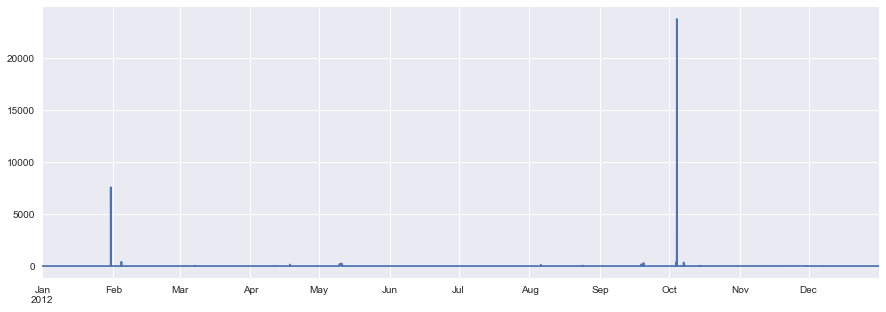

In [176]:
hourly['2012':'2012'].uid.plot(kind='line', figsize=(15,5))

threat    51743
dtype: int64

In [172]:
# Plot the average value by condition and date
ax = df.groupby(["threat",pd.Grouper(freq='H')]).count().plot()

TypeError: Empty 'DataFrame': no numeric data to plot

In [177]:
### Countplots

In [181]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### conn.log

In [179]:
conndf.select_dtypes(include=['object']).describe()

,conn_state,duration,history,id.orig_h,id.resp_h,local_orig,orig_bytes,proto,resp_bytes,sample,service,threat,tunnel_parents,uid
count,51743,51743,51743,51743,51743,51743,51743,51743,51743,51743,51743,51743,51743,51743
unique,13,38352,174,111,3861,1,3479,3,4629,95,9,3,2,51743
top,RSTO,-,ShAfR,192.168.248.165,10.0.2.255,-,0,tcp,-,BIN_Kuluoz-Asprox_9F842AD20C50AD1AAB41F20B321B...,-,CRIME,(empty),Ccf1Kq4YilW9TJ9di6
freq,20739,10920,9974,23641,2756,51743,21169,43381,10920,17510,31585,48725,51741,1


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

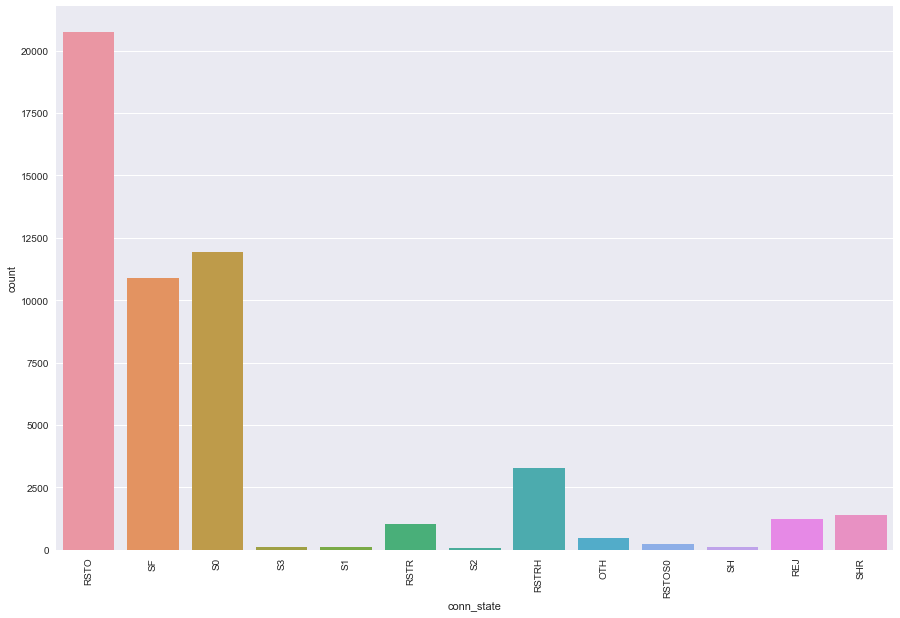

In [184]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(ax=ax, x="conn_state", data=conndf)
plt.xticks(rotation=90)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

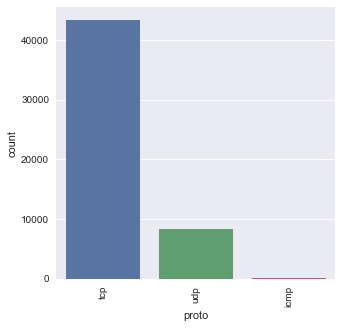

In [186]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(ax=ax, x="proto", data=conndf)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

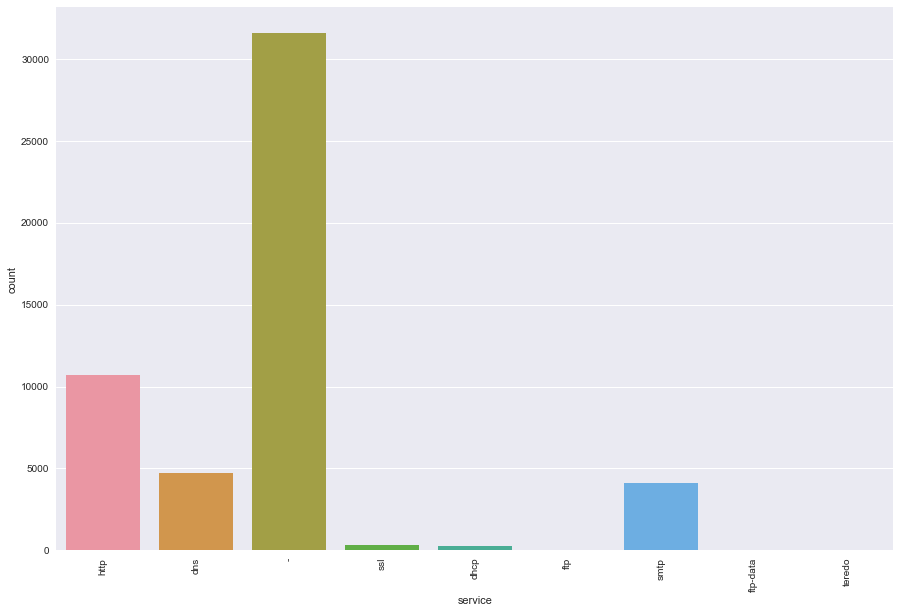

In [187]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(ax=ax, x="service", data=conndf)
plt.xticks(rotation=90)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

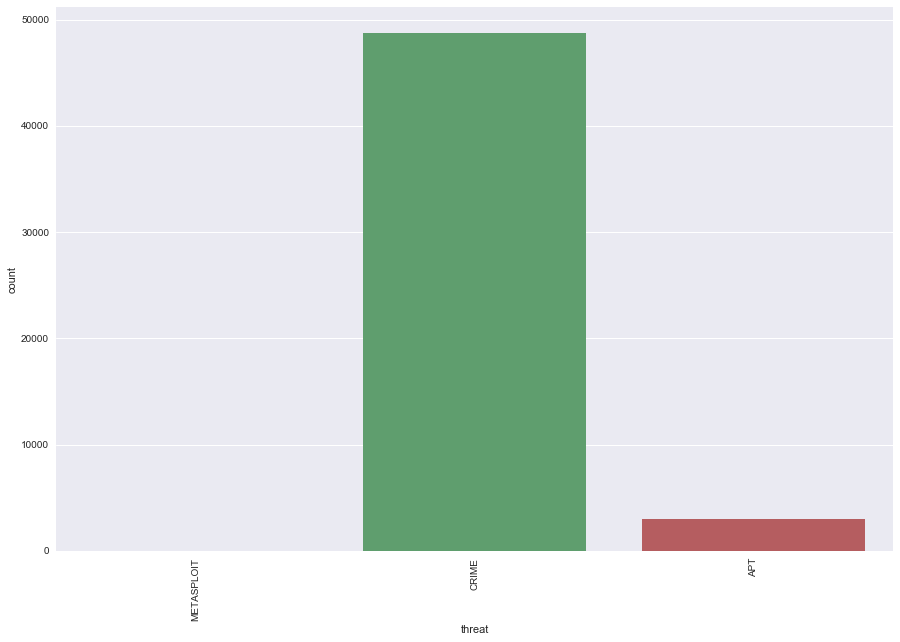

In [188]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(ax=ax, x="threat", data=conndf)
plt.xticks(rotation=90)

In [ ]:
#### dns.log

In [ ]:
dnsdf.select_dtypes(include=['object']).describe()